In [108]:
import numpy as np
import pandas as pd
# from sklearn.preprocessing import
from sklearn.model_selection import train_test_split
from random import randint
import sklearn.metrics as skm
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.metrics import roc_curve
from matplotlib import pyplot as plt

In [74]:
def replace_rare_entries(df, columns, threshold_frac):
    tot_instances = df.shape[0]
    threshold = tot_instances * threshold_frac
    df = df.apply(lambda x: x.mask(x.map(x.value_counts()) < threshold, 'RARE') if x.name in columns else x)
    return df
    

In [75]:
categoricals = ['OP_UNIQUE_CARRIER', 'DEST', 'DEP_TIME_BLK', 'DAY_OF_YEAR', 'DAY_OF_WEEK']
targets = ['DEP_DELAY_NEW', 'DEP_DEL15']

In [83]:
df = pd.read_csv('/home/dbeiski/PycharmProjects/flight_data/new_york/year_lga_dep.csv')

In [84]:
data = df.drop([col for col in df.columns if col not in categoricals], axis=1)
data = replace_rare_entries(data, ['DEST'], 0.005)
data = replace_rare_entries(data, ['UNIQUE_CARRIER'], 0.005)
data = pd.get_dummies(data, columns=categoricals)
label = df['DEP_DEL15']

In [85]:
data.columns

Index(['OP_UNIQUE_CARRIER_9E', 'OP_UNIQUE_CARRIER_AA', 'OP_UNIQUE_CARRIER_B6',
       'OP_UNIQUE_CARRIER_DL', 'OP_UNIQUE_CARRIER_EV', 'OP_UNIQUE_CARRIER_F9',
       'OP_UNIQUE_CARRIER_MQ', 'OP_UNIQUE_CARRIER_NK', 'OP_UNIQUE_CARRIER_OH',
       'OP_UNIQUE_CARRIER_OO',
       ...
       'DAY_OF_YEAR_9_7', 'DAY_OF_YEAR_9_8', 'DAY_OF_YEAR_9_9',
       'DAY_OF_WEEK_1', 'DAY_OF_WEEK_2', 'DAY_OF_WEEK_3', 'DAY_OF_WEEK_4',
       'DAY_OF_WEEK_5', 'DAY_OF_WEEK_6', 'DAY_OF_WEEK_7'],
      dtype='object', length=437)

In [86]:
data = data[~label.isna()]
label = label[~label.isna()]

In [87]:
print('Rows: {}\nFeatures: {}\nLabel-1 Fraction: {}'
      .format(data.shape[0], data.shape[1], label.sum() / label.shape[0]))

Rows: 181088
Features: 437
Label-1 Fraction: 0.21473537727513695


In [102]:
x_train, x_test, y_train, y_test = train_test_split(data, label, test_size=0.2,
                                                        random_state=randint(1, 500),
                                                        stratify=label)
xgbc.fit(x_train, y_train)
arg = (y_test, xgbc.predict(x_test))
print('Accuracy: {}\nRecall: {}\nPrecision: {}\nf1_Score: {}'.format(skm.accuracy_score(*arg), skm.recall_score(*arg), skm.precision_score(*arg), skm.f1_score(*arg)))

Accuracy: 0.7949362195593351
Recall: 0.054005400540054004
Precision: 0.8571428571428571
f1_Score: 0.10160880609652836


In [119]:
probas = xgbc.predict_proba(x_test)[:, 1]

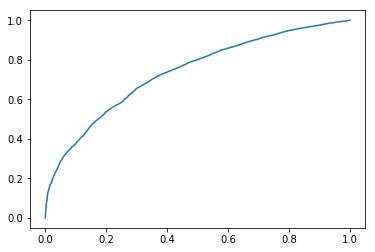

In [120]:
tpr, fpr, thres = roc_curve(y_test, probas)
plt.plot(tpr, fpr);

In [124]:
thres = np.linspace(0, 1, 500)

In [126]:
accs, recalls, precs, f1s = [], [], [], []
for thr in thres:
    y_pred = (probas > thr).astype(int)
    accs.append(skm.accuracy_score(y_test, y_pred))
    recalls.append(skm.recall_score(y_test, y_pred))
    precs.append(skm.precision_score(y_test, y_pred))
    f1s.append(skm.f1_score(y_test, y_pred))
    

/home/dbeiski/PycharmProjects/fl5/linear_models/venv3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dbeiski/PycharmProjects/fl5/linear_models/venv3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


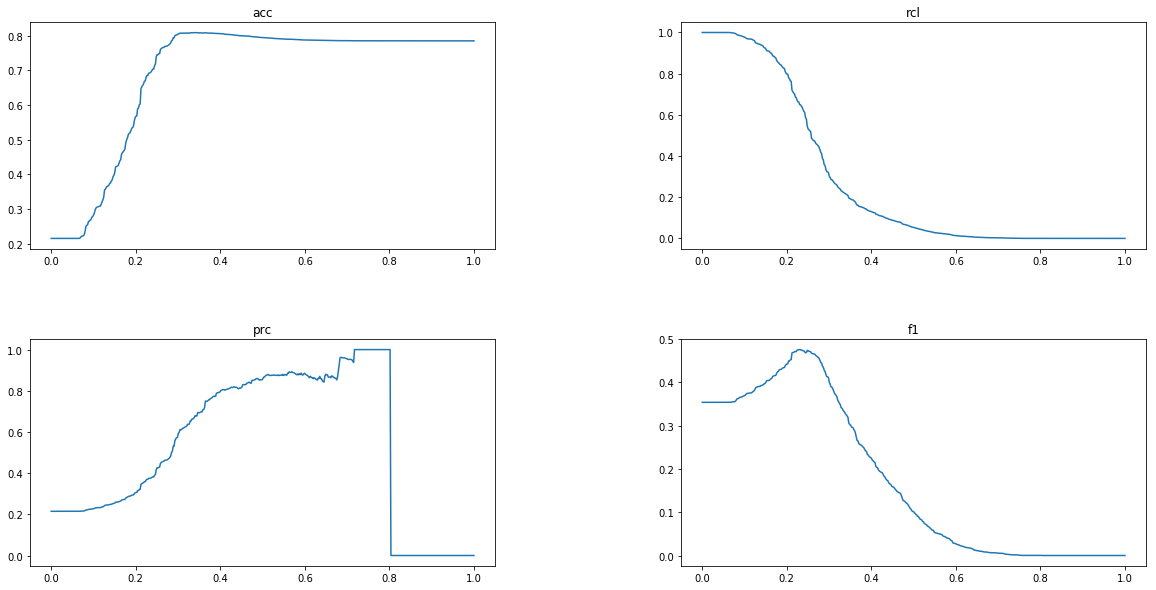

In [127]:
fig = plt.figure(figsize=(20, 10))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i, (metric, name) in enumerate(zip([accs, recalls, precs, f1s], ['acc', 'rcl', 'prc', 'f1']), start=1):
    fig.add_subplot(2, 2, i)
    plt.plot(thres, metric)
    plt.title(name)


In [133]:
best_thres = thres[np.argmax(f1s)]
y_pred = (probas > best_thres).astype(int)
print(skm.accuracy_score(y_test, y_pred))

0.6922248605665691


In [132]:
best_thres

0.34068136272545085

In [134]:
x, x_test, y, y_test = train_test_split(data, label, test_size=0.2, 
                                                        random_state=randint(1, 500),
                                                        stratify=label)

In [135]:
x_train, x_val, y_train, y_val = train_test_split(data, label, test_size=0.2, 
                                                        random_state=randint(1, 500),
                                                        stratify=label)
Dtrain = xgb.DMatrix(x_train, label=y_train)
Dval = xgb.DMatrix(x_val, label=y_val)

/home/dbeiski/PycharmProjects/fl5/linear_models/venv3.5/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [136]:
num_class = len(np.unique(y_train))
param = {                              # General guidelines for initial paramaters:
    'min_child_weight': 1,             # 1 (choose small for high class imbalance)
    'gamma': 0.5,                        # 0.1-0.2
    'lambda': 10,                       # L2 Regulariztion - default = 1
    'scale_pos_weight': 1,             # 1 (choose small for high class imbalance)
    'subsample': 0.6,                    # 0.5-0.9
    'colsample_bytree': 0.8,             # 0.5-0.9
    'colsample_bylevel': 0.7,              # 0.5-0.9
    'max_depth': 5,                    # 3-10 
    'eta': 0.1,                        # 0.05-0.3
    'silent': 0,                       # 0 - prints progress    1 - quiet
    'objective': 'binary:logistic',        
    'num_class': num_class,             
    'eval_metric': 'logloss'}  
num_round = 1000                                      # the number of training iterations if not stopped early
evallist = [(Dtrain, 'train'), (Dval, 'eval')]        # Specify validation set to watch performance

In [137]:
# Train the model on the training set to get an initial impression on the performance
model = xgb.train(param, Dtrain, num_round, evallist, early_stopping_rounds=10)
print("Best error: {:.2f} with {} rounds".format(
                 model.best_score,
                 model.best_iteration+1))

XGBoostError: [16:36:05] /workspace/src/objective/regression_obj.cu:65: Check failed: preds.Size() == info.labels_.Size() (289740 vs. 144870) : labels are not correctly providedpreds.size=289740, label.size=144870
Stack trace:
  [bt] (0) /home/dbeiski/PycharmProjects/fl5/linear_models/venv3.5/xgboost/libxgboost.so(dmlc::LogMessageFatal::~LogMessageFatal()+0x24) [0x7f9796c0acb4]
  [bt] (1) /home/dbeiski/PycharmProjects/fl5/linear_models/venv3.5/xgboost/libxgboost.so(xgboost::obj::RegLossObj<xgboost::obj::LogisticClassification>::GetGradient(xgboost::HostDeviceVector<float> const&, xgboost::MetaInfo const&, int, xgboost::HostDeviceVector<xgboost::detail::GradientPairInternal<float> >*)+0x21e) [0x7f9796e143ee]
  [bt] (2) /home/dbeiski/PycharmProjects/fl5/linear_models/venv3.5/xgboost/libxgboost.so(xgboost::LearnerImpl::UpdateOneIter(int, xgboost::DMatrix*)+0x345) [0x7f9796ca4505]
  [bt] (3) /home/dbeiski/PycharmProjects/fl5/linear_models/venv3.5/xgboost/libxgboost.so(XGBoosterUpdateOneIter+0x35) [0x7f9796c07aa5]
  [bt] (4) /usr/lib/python3.5/lib-dynload/_ctypes.cpython-35m-x86_64-linux-gnu.so(ffi_call_unix64+0x4c) [0x7f97f5460e20]
  [bt] (5) /usr/lib/python3.5/lib-dynload/_ctypes.cpython-35m-x86_64-linux-gnu.so(ffi_call+0x2eb) [0x7f97f546088b]
  [bt] (6) /usr/lib/python3.5/lib-dynload/_ctypes.cpython-35m-x86_64-linux-gnu.so(_ctypes_callproc+0x49a) [0x7f97f545b01a]
  [bt] (7) /usr/lib/python3.5/lib-dynload/_ctypes.cpython-35m-x86_64-linux-gnu.so(+0x9fcb) [0x7f97f544efcb]
  [bt] (8) /home/dbeiski/PycharmProjects/fl5/linear_models/venv3.5/bin/python(PyObject_Call+0x47) [0x5c20e7]



In [69]:
xgbc = XGBClassifier()
accs, recalls, precs, f1s = [], [], [], []
for i in range(10):
    x_train, x_test, y_train, y_test = train_test_split(data, label, test_size=0.2, 
                                                        random_state=randint(1, 500),
                                                        stratify=label)
    xgbc.fit(x_train, y_train)
    arg = (y_test, xgbc.predict(x_test))
    accs.append(skm.accuracy_score(*arg))
    recalls.append(skm.recall_score(*arg))
    precs.append(skm.precision_score(*arg))
    f1s.append(skm.f1_score(*arg))
    print('{} - Accuracy: {}\nRecall: {}\nPrecision: {}\nf1_Score: {}'
      .format(i, accs[-1], recalls[-1], precs[-1], f1s[-1]))
print('Avg: Accuracy: {}\nRecall: {}\nPrecision: {}\nf1_Score: {}'
      .format(np.mean(accs), np.mean(recalls), np.mean(precs), np.mean(f1s)))
    
    

0 - Accuracy: 0.7946877243359656
Recall: 0.05091283106196966
Precision: 0.88
f1_Score: 0.0962566844919786
1 - Accuracy: 0.7950190513004584
Recall: 0.054512728207765496
Precision: 0.8582995951417004
f1_Score: 0.10251450676982592
2 - Accuracy: 0.7939698492462312
Recall: 0.04885574697865775
Precision: 0.8558558558558559
f1_Score: 0.09243493067380198
3 - Accuracy: 0.794577282014468
Recall: 0.05065569555155567
Precision: 0.8755555555555555
f1_Score: 0.09577053962080699
4 - Accuracy: 0.7946325031752167
Recall: 0.05348418616610954
Precision: 0.8455284552845529
f1_Score: 0.10060459492140267
5 - Accuracy: 0.7952399359434535
Recall: 0.0542555926973515
Precision: 0.8755186721991701
f1_Score: 0.10217917675544795


KeyboardInterrupt: 